# EfficientNet-RetinaNet Object Detection

# Prepare Dataset

## Convert COCO to CSV dataset

In [8]:
import json
import pandas as pd
import os

def coco_to_csv(coco_json_path, images_dir, output_csv_path):
    """
    Convert COCO format annotations to CSV format
    
    Args:
        coco_json_path: Path to COCO annotation JSON file
        images_dir: Directory containing the images
        output_csv_path: Output CSV file path
    """
    
    # Load COCO annotations
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Create mappings
    image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
    category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Prepare data for CSV
    csv_data = []
    
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        bbox = annotation['bbox']  # [x, y, width, height] in COCO format
        
        # Convert COCO bbox to [xmin, ymin, xmax, ymax]
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = bbox[0] + bbox[2]
        ymax = bbox[1] + bbox[3]
        
        # Get image filename and create full path
        filename = image_id_to_filename[image_id]
        image_path = os.path.join(images_dir, filename)
        
        # Get category name
        label = category_id_to_name[category_id]
        
        csv_data.append({
            'image_path': image_path,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
            'label': label
        })
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(csv_data)
    df.to_csv(output_csv_path, index=False, header=False)
    
    print(f"Converted {len(csv_data)} annotations to {output_csv_path}")
    return df

In [7]:
data_dirs = ["train", "valid", "test"]

for dir in data_dirs:
    coco_json_path = f"../data/urine.v1i.coco.tiny/{dir}/_annotations.coco.json"
    images_dir = f"../data/urine.v1i.coco.tiny/{dir}"
    output_csv_path = f"../data/urine.v1i.coco.tiny/{dir}/_annotations.csv"

    # Convert COCO to CSV
    df = coco_to_csv(coco_json_path, images_dir, output_csv_path)

NameError: name 'coco_to_csv' is not defined

In [ ]:
df

# Training

This notebook contains the training pipeline for EfficientNet-RetinaNet object detection model.


In [6]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("../model")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import argparse
import collections
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms
from model_dataloader import (
    CSVDataset,
    collater,
    Resizer,
    AspectRatioBasedSampler,
    Augmenter,
    Normalizer,
)
from torch.utils.data import DataLoader
from eval import evaluate
from retinanet import RetinaNet_efficientnet_b4


## Training Function

The main training function that handles dataset loading, model initialization, and training loop.


In [10]:
def train(train_csv, test_csv, labels_csv, model_type, epochs, batch_size):
    """
    Train the EfficientNet-RetinaNet model
    
    Args:
        train_csv: Path to training CSV file
        test_csv: Path to test/validation CSV file  
        labels_csv: Path to class labels CSV file
        model_type: EfficientNet model type (b0-b5)
        epochs: Number of training epochs
        batch_size: Training batch size
    """
    
    # Create datasets
    dataset_train = CSVDataset(
        train_file=train_csv,
        class_list=labels_csv,
        transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]),
    )
    dataset_val = CSVDataset(
        train_file=test_csv,
        class_list=labels_csv,
        transform=transforms.Compose([Normalizer(), Resizer()]),
    )

    # Create data loader
    sampler = AspectRatioBasedSampler(
        dataset_train, batch_size=batch_size, drop_last=False
    )
    dataloader_train = DataLoader(
        dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler
    )

    # Initialize model
    retinanet = RetinaNet_efficientnet_b4(
        num_classes=dataset_train.num_classes(), model_type=model_type
    )

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    retinanet = retinanet.to(device)

    retinanet = torch.nn.DataParallel(retinanet).to(device)
    retinanet.training = True

    # Setup optimizer and scheduler
    optimizer = optim.Adam(retinanet.parameters(), lr=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=3
    )

    loss_hist = collections.deque(maxlen=500)

    retinanet.train()
    retinanet.module.freeze_bn()
    print("Num training images: {}".format(len(dataset_train)))

    # Training loop
    for epoch_num in range(epochs):
        retinanet.train()
        retinanet.module.freeze_bn()
        epoch_loss = []
        
        print(f"\n--- Epoch {epoch_num + 1}/{epochs} ---")
        
        for iter_num, data in enumerate(dataloader_train):
            try:
                optimizer.zero_grad()
                classification_loss, regression_loss = retinanet(
                    [data["img"].to(device).float(), data["annot"]]
                )
                classification_loss = classification_loss.mean()
                regression_loss = regression_loss.mean()
                loss = classification_loss + regression_loss
                
                if bool(loss == 0):
                    continue
                    
                loss.backward()
                torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)
                optimizer.step()
                loss_hist.append(float(loss))
                epoch_loss.append(float(loss))
                
                if iter_num % 10 == 0:  # Print every 10 iterations
                    print(
                        "Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | "
                        "Regression loss: {:1.5f} | Running loss: {:1.5f}".format(
                            epoch_num,
                            iter_num,
                            float(classification_loss),
                            float(regression_loss),
                            np.mean(loss_hist),
                        )
                    )
                    
                del classification_loss
                del regression_loss
                
            except Exception as e:
                print(f"Error in iteration {iter_num}: {e}")
                continue
                
        # Evaluation and model saving
        print("Evaluating...")
        _, MAP = evaluate(dataset_val, retinanet)
        print(f"Epoch {epoch_num} - mAP: {MAP:.4f}")
        
        scheduler.step(np.mean(epoch_loss))
        
        # Save epoch model
        torch.save(
            retinanet.module,
            "checkpoints/{}_retinanet_{}_map{:.4f}.pt".format(
                "EfficientNet" + model_type, epoch_num, MAP
            ),
        )
        
        # Save final model
        retinanet.eval()
        torch.save(retinanet, "runs/model_final.pt")
        
    print("Training completed!")


## Start Training


### Training Configuration

Set up the training parameters. Modify these values according to your dataset and requirements.


In [11]:
# Training parameters
train_csv = "data/urine.v1i.coco.tiny/train/_annotations.csv"
test_csv = "data/urine.v1i.coco.tiny/valid/_annotations.csv"
labels_csv = "data/urine.v1i.coco.tiny/classes.csv"
model_type = "b4"  # EfficientNet model type: ["b0", "b1", "b2", "b3", "b4", "b5"]
epochs = 2
batch_size = 8

# Display configuration
print(f"Training CSV: {train_csv}")
print(f"Test CSV: {test_csv}")
print(f"Labels CSV: {labels_csv}")
print(f"Model Type: EfficientNet-{model_type}")
print(f"Epochs: {epochs}")
print(f"Batch Size: {batch_size}")


Training CSV: data/urine.v1i.coco.tiny/train/_annotations.csv
Test CSV: data/urine.v1i.coco.tiny/valid/_annotations.csv
Labels CSV: data/urine.v1i.coco.tiny/classes.csv
Model Type: EfficientNet-b4
Epochs: 2
Batch Size: 8


Run the cell below to start training the model with the configured parameters.

In [12]:
# Start training
train(
    train_csv=train_csv,
    test_csv=test_csv, 
    labels_csv=labels_csv,
    model_type=model_type,
    epochs=epochs,
    batch_size=batch_size
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /Users/dikaizm/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


100.0%


Loaded pretrained weights for efficientnet-b4
Using device: cpu
Num training images: 617

--- Epoch 1/2 ---


KeyboardInterrupt: 

## Training Output

The training will:
- Print training progress for each epoch
- Show classification and regression losses
- Evaluate model performance (mAP) after each epoch
- Save model checkpoints with mAP scores in the filename
- Save a final model as `model_final.pt`

## Model Files

After training, you'll find:
- `EfficientNet{model_type}_retinanet_{epoch}_map{score}.pt` - Epoch checkpoints
- `model_final.pt` - Final trained model


# Inference


In [20]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("../model")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from __future__ import print_function, division
import torch
import numpy as np
import skimage.io
import skimage.transform
import skimage.color
import skimage
from model_dataloader import UnNormalizer
import time
import cv2
import argparse
import matplotlib.pyplot as plt
from IPython.display import Image, display


## Helper Classes and Functions

Define utility classes and functions for image preprocessing and visualization.


In [22]:
class Resize_Img:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, img, min_side=608, max_side=1024):
        image = img

        rows, cols, cns = image.shape

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        image = skimage.transform.resize(
            image, (int(round(rows * scale)), int(round((cols * scale))))
        )
        rows, cols, cns = image.shape

        pad_w = 32 - rows % 32
        pad_h = 32 - cols % 32

        new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)

        return {"img": torch.from_numpy(new_image), "scale": scale}


def collat(data):
    """Collate function for batching images."""
    imgs = data
    widths = [int(s.shape[0]) for s in imgs]
    heights = [int(s.shape[1]) for s in imgs]
    batch_size = 1

    max_width = np.array(widths).max()
    max_height = np.array(heights).max()

    padded_imgs = torch.zeros(batch_size, max_width, max_height, 3)

    for i in range(batch_size):
        img = imgs[i]
        img = torch.Tensor(img)
        padded_imgs[i, : int(img.shape[0]), : int(img.shape[1]), :] = img

    padded_imgs = padded_imgs.permute(0, 3, 1, 2)

    return padded_imgs


def draw_caption(image, box, caption):
    """Draw text caption on image with black outline."""
    b = np.array(box).astype(int)
    cv2.putText(
        image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2
    )
    cv2.putText(
        image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1
    )


## Inference Function

Main function to perform object detection inference on an image.


In [23]:
def run_inference(model_path, image_path, labels_csv, output_path, confidence_threshold=0.5):
    """
    Run object detection inference on an image.
    
    Args:
        model_path: Path to the trained model
        image_path: Path to the input image
        labels_csv: Path to the class labels CSV file
        output_path: Path to save the output image
        confidence_threshold: Minimum confidence for detections
        
    Returns:
        List of detections with bounding boxes and labels
    """
    
    # Load the trained model
    print("Loading model...")
    retinanet = torch.load(model_path, weights_only=False)
    
    # Load labels from CSV
    print("Loading class labels...")
    with open(labels_csv, 'r') as f:
        custom_labels = [line.strip().split(',')[0] for line in f.readlines()]

    label_map = {k: v + 1 for v, k in enumerate(custom_labels)}
    label_map["background"] = 0
    rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping
    
    print(f"Classes found: {custom_labels}")

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    retinanet = retinanet.to(device)

    unnormalize = UnNormalizer()
    retinanet.eval()

    # Load and preprocess image
    print(f"Loading image: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
        
    original_img = img.copy()
    img = img.astype(np.float32) / 255.0

    # Normalize image
    mean = np.array([[[0.485, 0.456, 0.406]]])
    std = np.array([[[0.229, 0.224, 0.225]]])
    img = (img.astype(np.float32) - mean) / std

    # Resize image
    image_resizer = Resize_Img()
    resized = image_resizer(img)
    img = resized["img"]
    scale = resized["scale"]

    # Prepare for inference
    img = np.expand_dims(img, axis=0)
    img = collat(img)

    # Run inference
    print("Running inference...")
    with torch.no_grad():
        start_time = time.time()
        scores, classification, transformed_anchors = retinanet(img.to(device).float())
        inference_time = time.time() - start_time
        print(f"Inference time: {inference_time:.4f} seconds")

    # Process results
    idxs = np.where(scores.cpu() > confidence_threshold)
    print(f"Found {len(idxs[0])} detections above confidence threshold {confidence_threshold}")

    # Prepare output image
    img_output = np.array(255 * unnormalize(img[0, :, :, :])).copy()
    img_output[img_output < 0] = 0
    img_output[img_output > 255] = 255
    img_output = np.transpose(img_output, (1, 2, 0))
    img_output = cv2.cvtColor(img_output.astype(np.uint8), cv2.COLOR_BGR2RGB)

    detections = []
    
    # Draw detections
    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
        
        label_idx = int(classification[idxs[0][j]])
        label_name = rev_label_map.get(label_idx, f"Unknown_{label_idx}")
        confidence = float(scores[idxs[0][j]])
        
        # Create caption with confidence
        caption = f"{label_name}: {confidence:.2f}"
        
        # Draw bounding box and label
        draw_caption(img_output, (x1, y1, x2, y2), caption)
        cv2.rectangle(img_output, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
        
        # Store detection info
        detection = {
            'label': label_name,
            'confidence': confidence,
            'bbox': [x1, y1, x2, y2]
        }
        detections.append(detection)
        
        print(f"Detection: {label_name} ({confidence:.3f}) at [{x1}, {y1}, {x2}, {y2}]")

    # Save output image
    cv2.imwrite(output_path, cv2.cvtColor(img_output, cv2.COLOR_RGB2BGR))
    print(f"Output saved to: {output_path}")
    
    return detections, img_output


## Run Inference

Execute the inference on your configured image. Make sure your model and image paths are correct.


In [24]:
# Inference parameters
model_path = "runs/model_final.pt"  # Path to your trained model
image_path = "../data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b44f2f95730955e701ddb37b0e3c8d51.jpg"  # Path to test image
anno_path = "../data/urine.v1i.coco.tiny/test/_annotations.csv"

labels_csv = "../data/urine.v1i.coco.tiny/classes.csv"  # Path to class labels
output_path = "predicts/inference_output.png"  # Output image path
confidence_threshold = 0.15  # Confidence threshold for detections

# Display configuration
print(f"Model path: {model_path}")
print(f"Image path: {image_path}")
print(f"Annotation path: {anno_path}")
print(f"Labels CSV: {labels_csv}")
print(f"Output path: {output_path}")
print(f"Confidence threshold: {confidence_threshold}")


Model path: runs/model_final.pt
Image path: ../data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b44f2f95730955e701ddb37b0e3c8d51.jpg
Annotation path: ../data/urine.v1i.coco.tiny/test/_annotations.csv
Labels CSV: ../data/urine.v1i.coco.tiny/classes.csv
Output path: predicts/inference_output.png
Confidence threshold: 0.15


In [25]:
# Run inference
try:
    detections, output_image = run_inference(
        model_path=model_path,
        image_path=image_path,
        labels_csv=labels_csv,
        output_path=output_path,
        confidence_threshold=confidence_threshold
    )
    
    print(f"\nInference completed successfully!")
    print(f"Total detections: {len(detections)}")
    
except Exception as e:
    print(f"Error during inference: {e}")
    print("Please check your file paths and model compatibility.")


Loading model...
Loading class labels...
Classes found: ['sediment', 'cast', 'cryst', 'epith', 'epithn', 'eryth', 'leuko', 'mycete']
Using device: cpu
Loading image: ../data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b44f2f95730955e701ddb37b0e3c8d51.jpg
Running inference...
Inference time: 1.0176 seconds
Found 3 detections above confidence threshold 0.15
Detection: leuko (0.182) at [742, 120, 790, 165]
Detection: leuko (0.181) at [443, 59, 489, 103]
Detection: leuko (0.166) at [379, 347, 428, 394]
Output saved to: predicts/inference_output.png

Inference completed successfully!
Total detections: 3


## Visualize Results

Display the original image, output image with detections, and detailed detection information.


In [26]:
import pandas as pd

# Define required columns
cols = ["image_path", "xmin", "ymin", "xmax", "ymax", "label"]
anno_df = pd.read_csv(anno_path, header=None, names=cols)
bbox_source = anno_df[anno_df['image_path'] == image_path.split("../")[-1]]

# Display the bounding box source
bbox_source

,image_path,xmin,ymin,xmax,ymax,label
390,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,473,12,494,33,eryth
391,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,18,14,38,34,eryth
392,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,443,18,468,43,eryth
393,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,652,11,676,39,eryth
394,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,327,23,345,42,eryth
...,...,...,...,...,...,...
491,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,555,144,575,165,eryth
492,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,463,135,482,156,eryth
493,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,439,257,462,278,eryth
494,data/urine.v1i.coco.tiny/test/nh00020_jpg.rf.b...,606,437,626,463,eryth


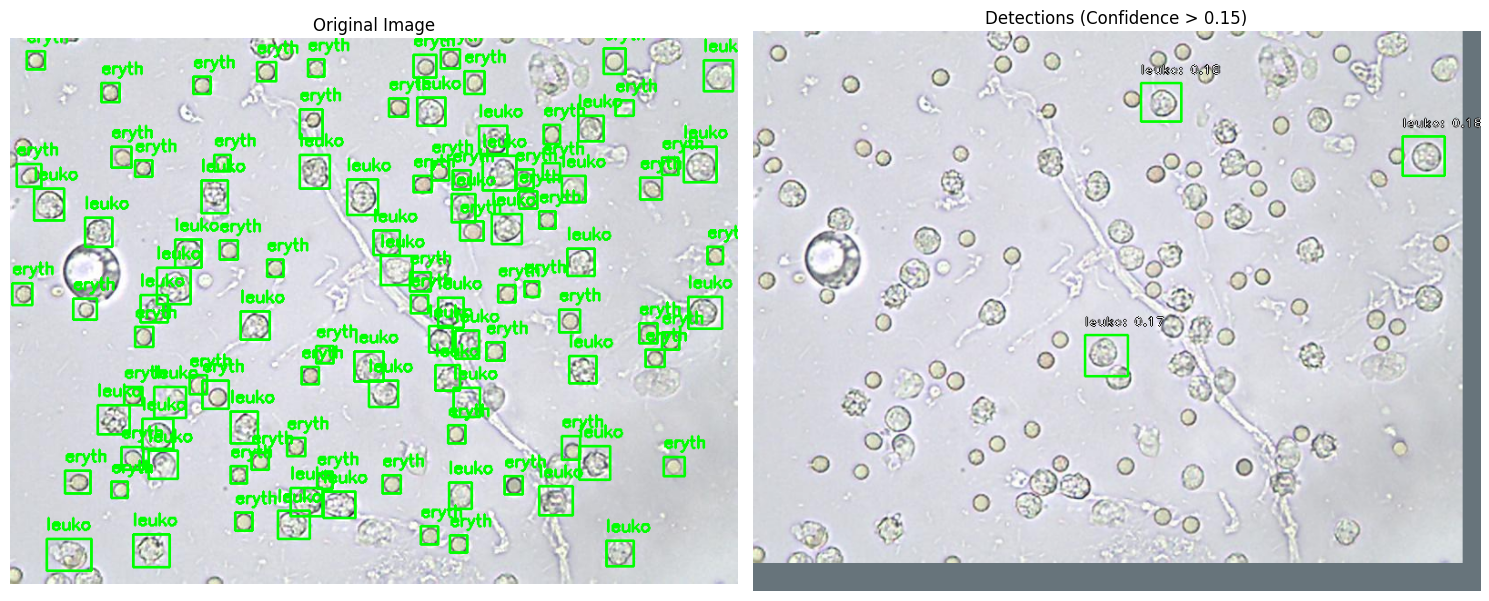


DETECTION RESULTS
Detection 1:
  Label: leuko
  Confidence: 0.182
  Bounding Box: [742, 120, 790, 165]

Detection 2:
  Label: leuko
  Confidence: 0.181
  Bounding Box: [443, 59, 489, 103]

Detection 3:
  Label: leuko
  Confidence: 0.166
  Bounding Box: [379, 347, 428, 394]



In [27]:
# Display results
if 'output_image' in locals() and 'detections' in locals():
    # Load original image for comparison
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Copy to draw ground truth boxes
    original_with_gt = original_img.copy()

    # Draw ground truth bounding boxes
    for _, row in bbox_source.iterrows():
        x1, y1, x2, y2 = int(row["xmin"]), int(row["ymin"]), int(row["xmax"]), int(row["ymax"])
        label = str(row["label"])
        cv2.rectangle(original_with_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(original_with_gt, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Display original image
    ax1.imshow(original_with_gt)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Display image with detections
    ax2.imshow(output_image)
    ax2.set_title(f'Detections (Confidence > {confidence_threshold})')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed detection information
    print("\n" + "="*50)
    print("DETECTION RESULTS")
    print("="*50)
    
    if detections:
        for i, detection in enumerate(detections, 1):
            print(f"Detection {i}:")
            print(f"  Label: {detection['label']}")
            print(f"  Confidence: {detection['confidence']:.3f}")
            print(f"  Bounding Box: {detection['bbox']}")
            print()
    else:
        print("No detections found above the confidence threshold.")
        print(f"Try lowering the confidence threshold (currently {confidence_threshold})")
        
else:
    print("Please run the inference first!")
